# Deep Learning RNN Model for Used Motorcycle Price Prediction
## IS794 AL - Deep Learning (Lab)
Kelompok B: <br>
- Daffa Kaisha Pratama Chandra (00000055770)
- Justine Donovan (00000063202)
- Marsella Patricia (00000063226)
- Reina Ratu Balqis (00000065099)
---
### Import Libraries

In [38]:
# Basic library
import pandas as pd
import numpy as np
from scipy import stats

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.express as px
from plotly.subplots import make_subplots

# Feature selection dengan random forest regressor
from sklearn.ensemble import RandomForestRegressor

# Deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout


# Ignore warning
import warnings
warnings.simplefilter("ignore")

---
Baca Dataset

In [39]:
yamaha = pd.read_csv("motor_yamaha_bekas.csv", engine='pyarrow')
honda = pd.read_csv("motor_honda_bekas.csv", engine='pyarrow')
kawasaki = pd.read_csv("motor_kawasaki_bekas.csv", engine='pyarrow')
suzuki = pd.read_csv("motor_suzuki_bekas.csv", engine='pyarrow')

Penjelasan singkat mengenai dataset yang digunakan: <br>
Dataset ini merupakan hasil web scraping dari website https://momotor.id/

In [40]:
print("Shape dari tiap dataset:")
print(f"Dataset Yamaha memiliki {yamaha.shape[1]} kolom dan {yamaha.shape[0]} baris.")
print(f"Dataset Honda memiliki {honda.shape[1]} kolom dan {honda.shape[0]} baris.")
print(f"Dataset Kawasaki memiliki {kawasaki.shape[1]} kolom dan {kawasaki.shape[0]} baris.")
print(f"Dataset Suzuki memiliki {suzuki.shape[1]} kolom dan {suzuki.shape[0]} baris.")

Shape dari tiap dataset:
Dataset Yamaha memiliki 10 kolom dan 493 baris.
Dataset Honda memiliki 10 kolom dan 966 baris.
Dataset Kawasaki memiliki 10 kolom dan 96 baris.
Dataset Suzuki memiliki 10 kolom dan 23 baris.


In [41]:
print("Informasi singkat dari tiap dataset:\n")
print("Yamaha:")
print(yamaha.info())
print("\nHonda:")
print(honda.info())
print("\nKawasaki:")
print(kawasaki.info())
print("\nSuzuki:")
print(suzuki.info())

Informasi singkat dari tiap dataset:

Yamaha:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_motor       352 non-null    object 
 1   lokasi           352 non-null    object 
 2   harga            352 non-null    object 
 3   deskripsi        352 non-null    object 
 4   kapasitas_mesin  352 non-null    object 
 5   tahun            352 non-null    float64
 6   transmisi        352 non-null    object 
 7   kilometer        352 non-null    object 
 8   url              493 non-null    object 
 9   merk             493 non-null    object 
dtypes: float64(1), object(9)
memory usage: 38.6+ KB
None

Honda:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_motor       629 non-null

Pre-process I: Data mentah -> Data siap pakai
Akan dilakukan cek <i> missing values. </i> Jika terdapat <i> missing values, </i> data yang hilang akan diimputasi menggunakan nilai modus. 

In [42]:
# Cek rata-rata missing values pada tiap dataset
brand = ['yamaha', 'honda', 'kawasaki', 'suzuki']
data = [yamaha, honda, kawasaki, suzuki]

for i, j in zip(brand, data):
    print(f"{i} missing values: \n{np.round(honda.isnull().mean(), 2)*100}")
    print()

yamaha missing values: 
nama_motor         35.0
lokasi             35.0
harga              35.0
deskripsi          35.0
kapasitas_mesin    35.0
tahun              35.0
transmisi          35.0
kilometer          35.0
url                 0.0
merk                0.0
dtype: float64

honda missing values: 
nama_motor         35.0
lokasi             35.0
harga              35.0
deskripsi          35.0
kapasitas_mesin    35.0
tahun              35.0
transmisi          35.0
kilometer          35.0
url                 0.0
merk                0.0
dtype: float64

kawasaki missing values: 
nama_motor         35.0
lokasi             35.0
harga              35.0
deskripsi          35.0
kapasitas_mesin    35.0
tahun              35.0
transmisi          35.0
kilometer          35.0
url                 0.0
merk                0.0
dtype: float64

suzuki missing values: 
nama_motor         35.0
lokasi             35.0
harga              35.0
deskripsi          35.0
kapasitas_mesin    35.0
tahun          

In [43]:
# cari modus dari tiap kolom yang terdapat missing values
kolom_null = ['nama_motor', 'lokasi', 'harga', 'deskripsi', 
              'kapasitas_mesin', 'tahun', 'transmisi', 'kilometer']

In [44]:
# Cari modus dan replace NaN dengan modus
for col in kolom_null:
    # Yamaha
    modus_yamaha = yamaha[col].value_counts().nlargest(3)
    # Honda
    modus_honda = yamaha[col].value_counts().nlargest(3)
    # Kawasaki
    modus_kawasaki = yamaha[col].value_counts().nlargest(3)
    # Suzuki
    modus_suzuki = yamaha[col].value_counts().nlargest(3)
    
    # Check if the mode values exist
    if len(modus_yamaha) >= 2:
        # Extract the mode strings
        modus_ymh1 = modus_yamaha.index[0]
        modus_ymh2 = modus_yamaha.index[1]

        # Define a list of possible string values between the modes
        possible_values_ymh = [modus_ymh1, modus_ymh2]

        # Replace NaN dengan nilai random antara modus pertama/kedua/ketiga
        yamaha[col] = yamaha[col].apply(lambda x: np.random.choice(possible_values_ymh) if pd.isna(x) else x)

    if len(modus_honda) >= 2:
        # Extract the mode strings
        modus_hnd1 = modus_honda.index[0]
        modus_hnd2 = modus_honda.index[1]

        # Define a list of possible string values between the modes
        possible_values_hnd = [modus_hnd1, modus_hnd2]

        # Replace NaN dengan nilai random antara modus pertama/kedua/ketiga
        honda[col] = honda[col].apply(lambda x: np.random.choice(possible_values_hnd) if pd.isna(x) else x)

    if len(modus_kawasaki) >= 2:
        # Extract the mode strings
        modus_kws1 = modus_kawasaki.index[0]
        modus_kws2 = modus_kawasaki.index[1]

        # Define a list of possible string values between the modes
        possible_values_kws = [modus_kws1, modus_kws2]

        # Replace NaN dengan nilai random antara modus pertama/kedua/ketiga
        kawasaki[col] = kawasaki[col].apply(lambda x: np.random.choice(possible_values_kws) if pd.isna(x) else x)

    if len(modus_suzuki) >= 2:
        # Extract the mode strings
        modus_szk1 = modus_suzuki.index[0]
        modus_szk2 = modus_suzuki.index[1]

        # Define a list of possible string values between the modes
        possible_values_szk = [modus_szk1, modus_szk2]

        # Replace NaN dengan nilai random antara modus pertama/kedua/ketiga
        suzuki[col] = suzuki[col].apply(lambda x: np.random.choice(possible_values_szk) if pd.isna(x) else x)

In [45]:
# Cek missing values lagi
for i, j in zip(brand, data):
    print(f"{i} missing values: \n{np.round(j.isnull().mean(), 2)*100}")
    print()

yamaha missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilometer          0.0
url                0.0
merk               0.0
dtype: float64

honda missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilometer          0.0
url                0.0
merk               0.0
dtype: float64

kawasaki missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilometer          0.0
url                0.0
merk               0.0
dtype: float64

suzuki missing values: 
nama_motor         0.0
lokasi             0.0
harga              0.0
deskripsi          0.0
kapasitas_mesin    0.0
tahun              0.0
transmisi          0.0
kilo

In [46]:
# Merge dataset
used_motor = pd.concat([yamaha, honda, kawasaki, suzuki])
print("Shape dari dataset yang digabung: ", used_motor.shape)
used_motor.head()

Shape dari dataset yang digabung:  (1578, 10)


,nama_motor,lokasi,harga,deskripsi,kapasitas_mesin,tahun,transmisi,kilometer,url,merk
0,Yamaha Aerox 155 Vva,Kab. Tangerang,"Rp23,500,000",Motor mulus dan bagus untuk surat-surat lengka...,155 CC,2018.0,Otomatis,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
1,Yamaha Nmax Abs,Kab. Tangerang,"Rp23,500,000",Motor mulus dan bagus untuk surat-surat lengka...,155 CC,2018.0,Otomatis,10000 - 20000KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
2,Yamaha Nmax Abs,Kota Jakarta Barat,"Rp23,500,000",Motor mulus dan bagus untuk surat-surat lengka...,125 CC,2019.0,Otomatis,10000 - 20000KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
3,Yamaha Aerox 155 Vva,Kab. Tangerang,"Rp23,500,000",Motor mulus dan bagus untuk surat-surat lengka...,155 CC,2019.0,Otomatis,10000 - 20000KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha
4,Yamaha Aerox 155 Vva,Kota Jakarta Barat,"Rp24,500,000",Motor mulus dan bagus untuk surat-surat lengka...,155 CC,2019.0,Manual,>30000 KM,https://www.momotor.id/motor-bekas/yamaha/yama...,Yamaha


---
#### Data Pre-processing
Pada tahap ini, akan dilakukan:
- <i>Remove missing values</i>
- Membersihkan kolom harga
- Membersihkan kolom kapasitas mesin

##### Drop variabel yang tidak dibutuhkan

In [47]:
used_motor = used_motor.drop(columns=['deskripsi', 'url'])
used_motor.head()

,nama_motor,lokasi,harga,kapasitas_mesin,tahun,transmisi,kilometer,merk
0,Yamaha Aerox 155 Vva,Kab. Tangerang,"Rp23,500,000",155 CC,2018.0,Otomatis,>30000 KM,Yamaha
1,Yamaha Nmax Abs,Kab. Tangerang,"Rp23,500,000",155 CC,2018.0,Otomatis,10000 - 20000KM,Yamaha
2,Yamaha Nmax Abs,Kota Jakarta Barat,"Rp23,500,000",125 CC,2019.0,Otomatis,10000 - 20000KM,Yamaha
3,Yamaha Aerox 155 Vva,Kab. Tangerang,"Rp23,500,000",155 CC,2019.0,Otomatis,10000 - 20000KM,Yamaha
4,Yamaha Aerox 155 Vva,Kota Jakarta Barat,"Rp24,500,000",155 CC,2019.0,Manual,>30000 KM,Yamaha


In [48]:
# Lihat nilai unik dari setiap kolom
kolom = used_motor.columns

for i in kolom:
    print(f"Nilai unik dari kolom {i}:")
    print(used_motor[i].unique())

Nilai unik dari kolom nama_motor:
['Yamaha Aerox 155 Vva' 'Yamaha Nmax Abs' 'Yamaha Lexi S'
 'Yamaha Jupiter Mx Cw' 'Yamaha All New Nmax 155' 'Yamaha Fino Sporty'
 'Yamaha Gear 125' 'Yamaha Gear 125 S-version' 'Yamaha All New Xsr 155'
 'Yamaha R15 Gp Tech 3' 'Yamaha Scorpio G' 'Yamaha Vixion Extreme'
 'Yamaha R15 Gp Movistar' 'Yamaha R15' 'Yamaha All New R15 155 Vva'
 'Yamaha Mio Z 125' 'Yamaha WR 155 R' 'Yamaha Mio Cw'
 'Yamaha All New Nmax 155 Abs' 'Yamaha Freego' 'Yamaha Aerox 155 Vva-s'
 'Yamaha Lexi' 'Yamaha New Mio M3 Cw' 'Yamaha N Max' 'Yamaha Mio'
 'Yamaha New Vixion' 'Yamaha XMAX' 'Yamaha All New X-ride 125'
 'Yamaha Nmax Special Custom' 'Yamaha Fazzio Neo'
 'Yamaha All New Nmax 155 Con' 'Yamaha X Ride Se' 'Yamaha Xmax Abs'
 'Yamaha Xmax' 'Yamaha X-ride' 'Yamaha Fino Sport 125 Blu Cr'
 'Yamaha Aerox 155 Vva R' 'Yamaha All New Vixion R'
 'Yamaha New V Ixion Adv Gp' 'Yamaha Mio M3 125' 'Yamaha New Aerox 155 C'
 'Yamaha Fino Grade 125' 'Yamaha R25' 'Yamaha Fino Premium Fi Se'
 'Y

Kolom kapasitas mesin dan harga belum dalam format yang benar

##### Membersihkan kolom harga

In [49]:
def clean_harga(harga):
    harga_clean = harga.replace("Rp", "").replace(".", "").replace(",", "")
    return harga_clean

used_motor['harga'] = used_motor['harga'].apply(clean_harga)
# used_motor['harga'] = pd.to_numeric(used_motor['harga'], errors='coerce', downcast='integer')
# used_motor['harga'] = pd.to_numeric(used_motor['harga'], errors='coerce')
used_motor['harga'] = used_motor['harga'].astype("float")

##### Membersihkan kolom kapasitas mesin

In [50]:
def clean_cc(kapasitas_mesin):
    cc_clean = kapasitas_mesin.replace("cc", "")
    cc_clean2 = cc_clean.replace(" CC", "")
    cc_clean3 = cc_clean2.replace("Cc", "")
    cc_clean4 = cc_clean3.replace("CC", "")
    cc_clean5 = cc_clean4.replace("p", "")
    return cc_clean5

used_motor['kapasitas_mesin'] = used_motor['kapasitas_mesin'].apply(clean_cc)
used_motor['kapasitas_mesin'] = used_motor['kapasitas_mesin'].replace(['-', ''], 150)
used_motor['kapasitas_mesin'] = used_motor['kapasitas_mesin'].replace('1550', 150)
used_motor = used_motor[used_motor['kapasitas_mesin'] != 'DSE4202201']
used_motor['kapasitas_mesin'] = used_motor['kapasitas_mesin'].astype('int')
print(used_motor['kapasitas_mesin'].unique())

[155 125 220 150 250 156 110 249 115 160  11 113 900 175 600]


Cek outliers

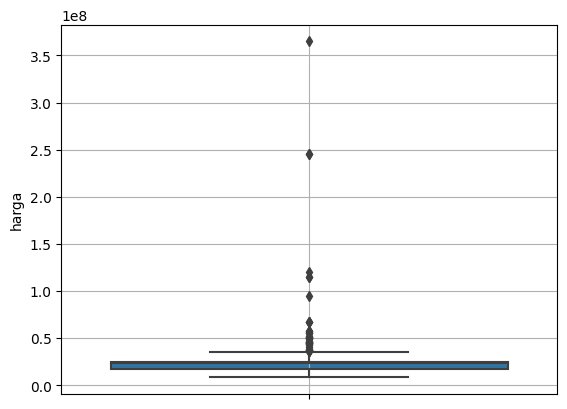

In [51]:
sns.boxplot(y=used_motor['harga'])
plt.grid()
plt.show()

In [52]:
# Calculate the IQR
Q1 = used_motor['harga'].quantile(0.25)
Q3 = used_motor['harga'].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers based on IQR
filtered_motor = used_motor[(used_motor['harga'] > Q1 - 1.5 * IQR) & (used_motor['harga'] < Q3 + 1.5 * IQR)]

<Axes: ylabel='harga'>

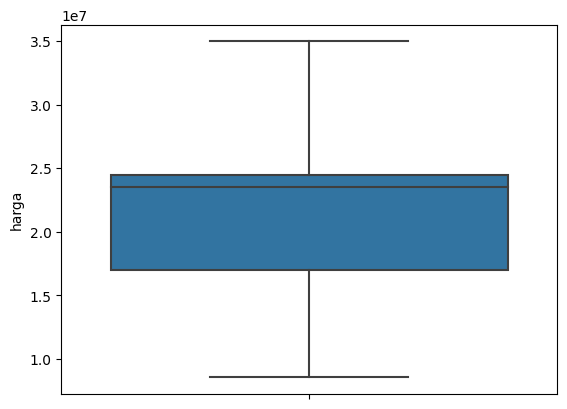

In [53]:
sns.boxplot(y=filtered_motor['harga'])

In [54]:
print(f"Shape dari dataset setelah mengatasi outliers:\n{filtered_motor.shape[0]} baris dan {filtered_motor.shape[1]} kolom")

Shape dari dataset setelah mengatasi outliers:
1533 baris dan 8 kolom


---
#### Exploratory Data Analysis <br>
Pada tahap EDA, akan dilakukan beberapa tahapan untuk menemukan pola pada data dengan menggunakan statistik dan visualisasi data. Beberapa tahapan yang akan dilakukan sebagai berikut:
- Melihat informasi data
- Melihat nilai unik tiap kolom
- Melihat statistika dasar
- Visualisasi data

In [55]:
# Melihat informasi dataset
filtered_motor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1533 entries, 0 to 22
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nama_motor       1533 non-null   object 
 1   lokasi           1533 non-null   object 
 2   harga            1533 non-null   float64
 3   kapasitas_mesin  1533 non-null   int32  
 4   tahun            1533 non-null   float64
 5   transmisi        1533 non-null   object 
 6   kilometer        1533 non-null   object 
 7   merk             1533 non-null   object 
dtypes: float64(2), int32(1), object(5)
memory usage: 101.8+ KB


In [56]:
# Loop melalui tiap kolom dan mencetak nilai unik
unique_value_count ={}
for column in filtered_motor.columns : 
    unique_values = filtered_motor[column].unique()
    unique_count = len(unique_values)
    unique_value_count[column] = unique_count

for column, count in unique_value_count.items():
    print(f"{column} : {count}")

nama_motor : 139
lokasi : 16
harga : 229
kapasitas_mesin : 12
tahun : 8
transmisi : 2
kilometer : 5
merk : 4


In [57]:
# Melihat Statistika data numerik
filtered_motor.describe()

,harga,kapasitas_mesin,tahun
count,1.533000e+03,1533.000000,1533.000000
mean,2.113275e+07,135.610568,2018.662100
std,5.039502e+06,18.946133,1.478958
min,8.550000e+06,11.000000,2015.000000
25%,1.700000e+07,125.000000,2018.000000
50%,2.350000e+07,125.000000,2019.000000
75%,2.450000e+07,155.000000,2019.000000
max,3.500000e+07,250.000000,2022.000000


In [58]:
# Melihat Statistika data kategorikal
filtered_motor.describe(exclude=np.number)

,nama_motor,lokasi,transmisi,kilometer,merk
count,1533,1533,1533,1533,1533
unique,139,16,2,5,4
top,Yamaha Nmax Abs,Kota Jakarta Barat,Otomatis,10000 - 20000KM,Honda
freq,343,463,1143,631,956


<Axes: xlabel='harga', ylabel='Count'>

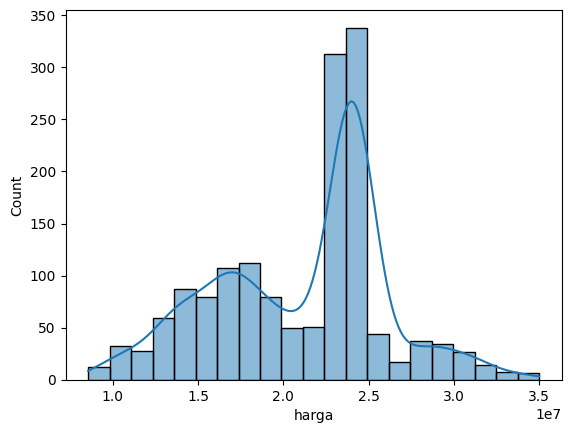

In [59]:
# Visualisasi distribusi harga motor semua merk
sns.histplot(filtered_motor['harga'], kde=True)

In [60]:
# Visualisasi distribusi harga tiap merk motor
# Subplot
fig = make_subplots(rows=2, cols=2, subplot_titles=['Honda', 'Yamaha', 'Kawasaki', 'Suzuki'])

# Plot for Honda Turbo aspiration
fig.add_trace(px.histogram(filtered_motor[filtered_motor['merk'] == 'Honda'], x='harga', nbins=30, color_discrete_sequence=['#ca91eb']).update_traces(histnorm='probability').data[0], row=1, col=1)

# Plot for Yamaha Std aspiration
fig.add_trace(px.histogram(filtered_motor[filtered_motor['merk'] == 'Yamaha'], x='harga', nbins=30, color_discrete_sequence=['#eb6426']).update_traces(histnorm='probability').data[0], row=1, col=2)

# Plot for Kawasaki Std aspiration
fig.add_trace(px.histogram(filtered_motor[filtered_motor['merk'] == 'Kawasaki'], x='harga', nbins=30, color_discrete_sequence=['#91caeb']).update_traces(histnorm='probability').data[0], row=2, col=1)

# Plot for Suzuki Std aspiration
fig.add_trace(px.histogram(filtered_motor[filtered_motor['merk'] == 'Suzuki'], x='harga', nbins=30, color_discrete_sequence=['#265aeb']).update_traces(histnorm='probability').data[0], row=2, col=2)

# Update layout
fig.update_layout(showlegend=False, title_text="Distribusi Harga Tiap Merk Motor")

# Show the plot
fig.show()


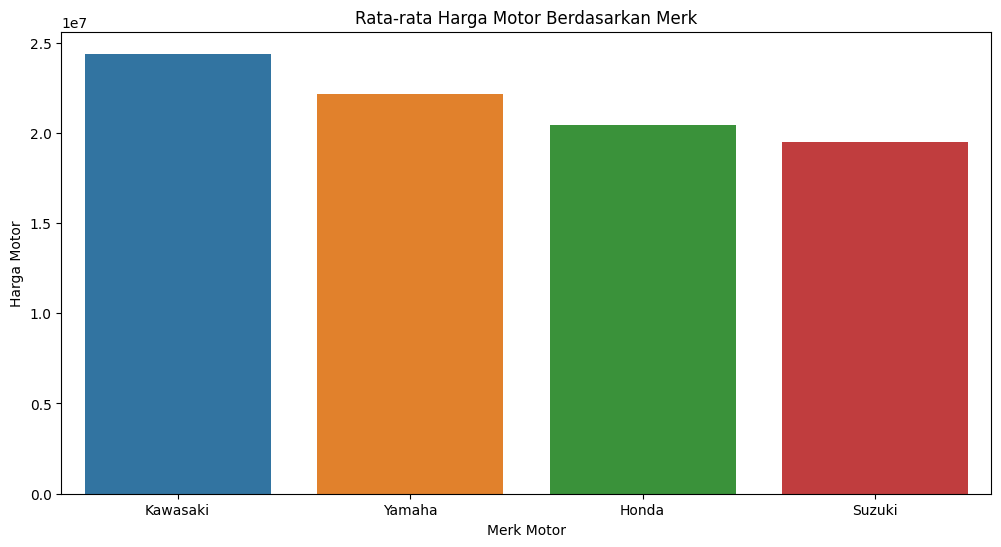

In [61]:
# Visualisasi Rata-Rata Harga Motor

hargapermerk = filtered_motor.groupby("merk")["harga"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="merk", y="harga", data=hargapermerk, order=hargapermerk.sort_values('harga', ascending=False)['merk'])
plt.title("Rata-rata Harga Motor Berdasarkan Merk")
plt.xlabel("Merk Motor")
plt.ylabel("Harga Motor")
plt.show()


Dari visualisasi, terlihat rata-rata harga paling mahal adalah merk motor Kawasaki

### Data Preparation

##### Membuat kategori baru untuk kolom kilometer

In [62]:
filtered_motor['kilometer_kategori'] = filtered_motor['kilometer'].replace({'>30000 KM': 'Tinggi', 
                                                                    '5000 - 10000KM' and '10000 - 20000KM': 'Sedang',  
                                                                    '1000 - 5000 KM': 'Rendah'})

In [63]:
filtered_motor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1533 entries, 0 to 22
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama_motor          1533 non-null   object 
 1   lokasi              1533 non-null   object 
 2   harga               1533 non-null   float64
 3   kapasitas_mesin     1533 non-null   int32  
 4   tahun               1533 non-null   float64
 5   transmisi           1533 non-null   object 
 6   kilometer           1533 non-null   object 
 7   merk                1533 non-null   object 
 8   kilometer_kategori  1533 non-null   object 
dtypes: float64(2), int32(1), object(6)
memory usage: 113.8+ KB


##### Encoding

In [64]:
# Initialize LabelEncoder
le = LabelEncoder()

# Select column wiht categorical values
cols = ['lokasi', 'transmisi', 'kilometer_kategori', 'merk']
for i in cols:
    filtered_motor[i] = le.fit_transform(filtered_motor[i]) + 1

# Check the data
filtered_motor.head()

,nama_motor,lokasi,harga,kapasitas_mesin,tahun,transmisi,kilometer,merk,kilometer_kategori
0,Yamaha Aerox 155 Vva,4,23500000.0,155,2018.0,2,>30000 KM,4,5
1,Yamaha Nmax Abs,4,23500000.0,155,2018.0,2,10000 - 20000KM,4,4
2,Yamaha Nmax Abs,9,23500000.0,125,2019.0,2,10000 - 20000KM,4,4
3,Yamaha Aerox 155 Vva,4,23500000.0,155,2019.0,2,10000 - 20000KM,4,4
4,Yamaha Aerox 155 Vva,9,24500000.0,155,2019.0,1,>30000 KM,4,5


##### MinMax Scaler

##### Feature Selection

In [65]:
# Choosing X and y
X = filtered_motor.drop(columns=['harga', 'kilometer', 'nama_motor'])
y = filtered_motor['harga']

In [66]:
# Train test split untuk feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [67]:
# Initialize MinMaxScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [68]:
# Random forest regressor untuk memilih feature importance
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

RandomForestRegressor()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


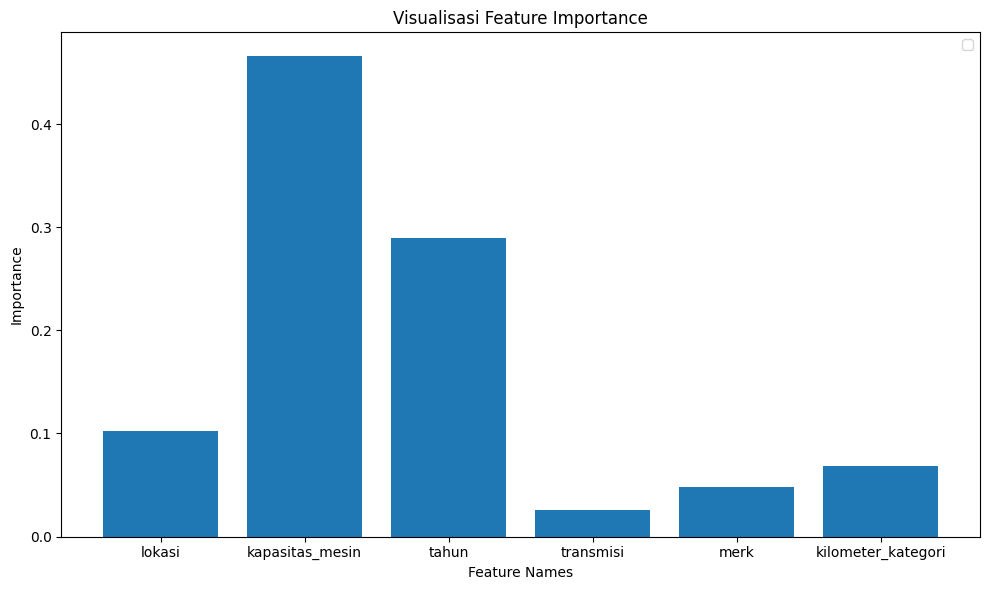

In [69]:
rf_fi = rf.feature_importances_

# Define Nama columns
feature_names = X.columns.tolist()

plt.figure(figsize=(10, 6))

# Plotting feature importances
plt.bar(feature_names, rf_fi)
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Visualisasi Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()

---
#### Modeling
Pada tahap modeling, akan dilakukan:
- Seleksi fitur
- Membangun model RNN
- Tuning hyperparameter

Seleksi fitur

In [70]:
# Choosing X and y
X = filtered_motor.drop(columns=['harga', 'kilometer', 'nama_motor'])
y = filtered_motor['harga']

In [71]:
# Train test split untuk feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [72]:
# Initialize MinMaxScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [73]:
# Reshape
n_feat = X.shape[1]
X_train_reshape = X_train_scaled.reshape(-1,1,n_feat)
X_test_reshape = X_test_scaled.reshape(-1,1,n_feat)

Modeling
- Tanpa tuning hyperparameter

In [76]:
from tensorflow.keras.layers import LSTM

# Build the RNN model
model = Sequential()
model.add(Dense(units=64, input_dim=6, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2561 (10.00 KB)
Trainable params: 2561 (10.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=1, validation_data=(X_test_scaled, y_test))

Epoch 1/10
1226/1226 [==============================] - 6s 4ms/step - loss: 474231196352512.0000 - mean_squared_error: 474231196352512.0000 - val_loss: 462961000841216.0000 - val_mean_squared_error: 462961000841216.0000
Epoch 2/10
1226/1226 [==============================] - 5s 4ms/step - loss: 474226230296576.0000 - mean_squared_error: 474226230296576.0000 - val_loss: 462960363307008.0000 - val_mean_squared_error: 462960363307008.0000
Epoch 3/10
1226/1226 [==============================] - 5s 4ms/step - loss: 474223243952128.0000 - mean_squared_error: 474223243952128.0000 - val_loss: 462959490891776.0000 - val_mean_squared_error: 462959490891776.0000
Epoch 4/10
1226/1226 [==============================] - 5s 4ms/step - loss: 474222304428032.0000 - mean_squared_error: 474222304428032.0000 - val_loss: 462958048051200.0000 - val_mean_squared_error: 462958048051200.0000
Epoch 5/10
1226/1226 [==============================] - 5s 4ms/step - loss: 474221163577344.0000 - mean_squared_error: 4

In [79]:
loss = model.evaluate(X_test_scaled, y_test)
print(loss)

10/10 [==============================] - 0s 4ms/step - loss: 462950531858432.0000 - mean_squared_error: 462950531858432.0000
[462950531858432.0, 462950531858432.0]


In [80]:
y_pred = model.predict(X_test_scaled)
r2_score(y_test, y_pred)

10/10 [==============================] - 0s 2ms/step


-19.099160800815138

Tuning Hyperparameter <br>
....

Finalisasi Model
....

---
#### Evaluasi

Terlihat model .....

---
#### Save model
Model yang dengan akurasi tertinggi akan disimpan untuk di <i> deploy </i>